In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from folium.plugins import HeatMap

In [124]:
registrations = pd.read_csv('data/vehicle_registrations.csv')

registrations.rename(columns={'Electric (EV)': 'Electric'}, inplace=True)

columns_to_int = ['Electric', 'Plug-In Hybrid Electric (PHEV)', 'Hybrid Electric (HEV)', 'Biodiesel', 'Ethanol/Flex (E85)', 'Compressed Natural Gas (CNG)', 'Propane', 'Hydrogen', 'Gasoline', 'Diesel', 'Unknown Fuel']

for column_name, values in registrations.items():
    if column_name != 'State':
        registrations[column_name] = registrations[column_name].replace({',': ''}, regex=True).astype(int)
        
registrations['Hybrid'] = registrations['Plug-In Hybrid Electric (PHEV)'] + registrations['Hybrid Electric (HEV)']
columns_to_remove = ['Plug-In Hybrid Electric (PHEV)', 'Hybrid Electric (HEV)']
registrations = registrations.drop(columns=columns_to_remove)

registrations['Fuel'] = registrations['Gasoline'] + registrations['Diesel']
columns_to_remove = ['Gasoline', 'Diesel']
registrations = registrations.drop(columns=columns_to_remove)

registrations['Other'] = registrations['Biodiesel'] + registrations['Ethanol/Flex (E85)'] + registrations['Compressed Natural Gas (CNG)'] + registrations['Propane'] + registrations['Hydrogen'] + registrations['Methanol'] + registrations['Unknown Fuel']
columns_to_remove = ['Biodiesel', 'Ethanol/Flex (E85)', 'Compressed Natural Gas (CNG)', 'Propane', 'Hydrogen', 'Methanol', 'Unknown Fuel']
registrations = registrations.drop(columns=columns_to_remove)

In [125]:

columns_to_keep = ['Fuel Type Code', 'State', 'Latitude', 'Longitude', 'Open Date']
stations = pd.read_csv('data/alt_fuel_stations (Dec 2 2023).csv', usecols=columns_to_keep, engine='python')
stations['Open Date'] = pd.to_datetime(stations['Open Date'], format='%Y-%m-%d')

# Datenüberblick
print(stations.info())
print(stations.head())
print(stations.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68016 entries, 0 to 68015
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Fuel Type Code  68016 non-null  object        
 1   State           68002 non-null  object        
 2   Latitude        68016 non-null  float64       
 3   Longitude       68016 non-null  float64       
 4   Open Date       67868 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 2.6+ MB
None
  Fuel Type Code State   Latitude   Longitude  Open Date
0           ELEC    CA  34.248319 -118.387971 1999-10-15
1           ELEC    CA  34.052542 -118.448504 2020-02-28
2           ELEC    CA  34.040539 -118.271387 1995-08-30
3           ELEC    CA  34.059133 -118.248589 1999-10-15
4           ELEC    CA  33.759802 -118.096665 2018-05-01
           Latitude     Longitude
count  68016.000000  68016.000000
mean      37.769263    -96.831422
std     

In [126]:
# Anzahl der fehlenden Werte
usa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   State         51 non-null     object
 1   Abbreviation  51 non-null     object
 2   Vote          51 non-null     object
 3   Population    51 non-null     int64 
 4   Land_area     51 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.1+ KB


In [127]:
usa = pd.read_csv('data/usa.csv')

columns_to_int = ['Population', 'Land_area']

for column in columns_to_int:
    usa[column] = usa[column].replace({',': ''}, regex=True).astype(int)

### Geografische Verteilung der Ladesäulen

In [128]:
# Wie sind die Ladesäulen in den USA geografisch verteilt
map_center = [stations['Latitude'].mean(), stations['Longitude'].mean()]
my_map = folium.Map(location=map_center, zoom_start=4)
heat_data = [[row['Latitude'], row['Longitude']] for index, row in stations.iterrows()]
HeatMap(heat_data, radius=10, blur=7).add_to(my_map)
my_map.save("heatmap.html")

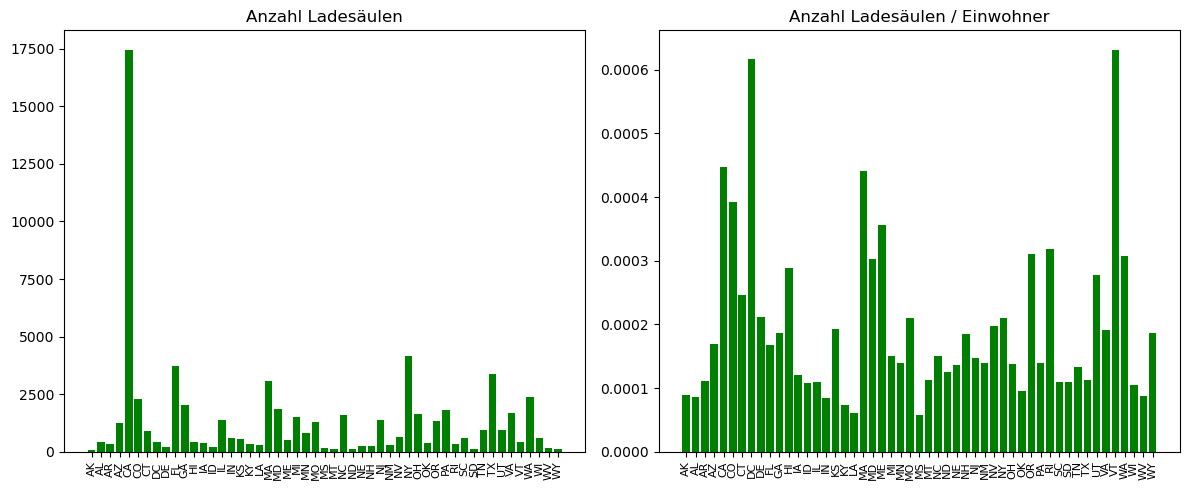

In [129]:
# Welche Bundestaaten haben die höchste bzw. niedrigste Anzahl an Ladesäulen
stations_per_state = stations.groupby('State').size().reset_index(name='Count')
stations_per_state = pd.merge(stations_per_state, usa, left_on='State', right_on='Abbreviation')

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].bar(stations_per_state['Abbreviation'], stations_per_state['Count'], color='green')
axs[0].set_title('Anzahl Ladesäulen')
axs[0].set_xticks(axs[0].get_xticks())
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, fontsize=8)

stations_pop = stations_per_state['Count'] / stations_per_state['Population']
axs[1].bar(stations_per_state['Abbreviation'], stations_pop, color='green')
axs[1].set_title('Anzahl Ladesäulen / Einwohner')
axs[1].set_xticks(axs[1].get_xticks())
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

### Zeitliche Entwicklung der Ladesäulen

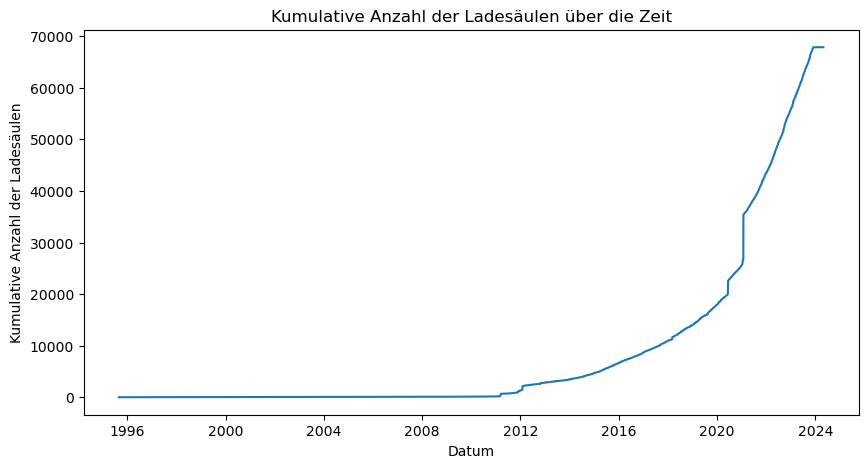

In [130]:
# Wie hat sich die Anzahl der Ladesäulen im Laufe der Zeit entwickelt
stations_dev = stations.groupby(stations['Open Date'].dt.date).size().cumsum().reset_index(name='Count')

plt.figure(figsize=(10,5))
plt.plot(stations_dev['Open Date'], stations_dev['Count'], linestyle='-')
plt.title('Kumulative Anzahl der Ladesäulen über die Zeit')
plt.xlabel('Datum')
plt.ylabel('Kumulative Anzahl der Ladesäulen')
plt.show()

/var/folders/1n/76f51gz14z3d8jfl34xk49zw0000gn/T/ipykernel_64377/1653853497.py:27: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  s20 = stations_dev.loc[stations_dev['Open Date'] > pd.to_datetime('2020-01-01')]
/var/folders/1n/76f51gz14z3d8jfl34xk49zw0000gn/T/ipykernel_64377/1653853497.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  s23 = stations_dev.loc[stations_dev['Open Date'] > pd.to_datetime('2023-01-01')]


37852


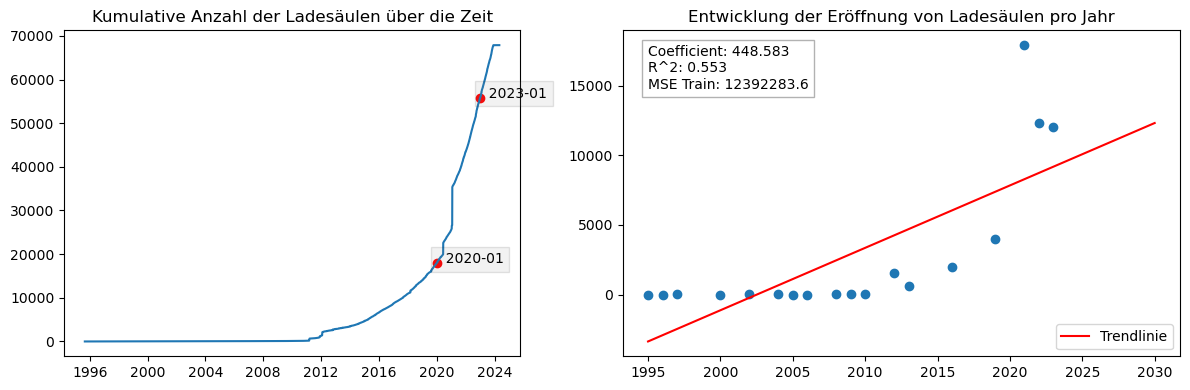

In [172]:
# Wie hat sich die Anzahl der Ladesäulen im Laufe der Zeit entwickelt
# Gibt es einen Trend in der Eröffnung von Ladesäulen über die Jahre?
stations_trend = stations.groupby(stations['Open Date'].dt.year).size().reset_index(name='Count')
# es gibt eine Station 2024 im Datensatz
stations_trend = stations_trend[stations_trend['Open Date'] != 2024]

regressor = LinearRegression()
# Input-Variable
x_reg = stations_trend['Open Date']
# Output-Variable
y_reg = stations_trend['Count']

# Aufteilen in Test- und Trainingsdatensatz 
x_reg_train,x_reg_test,y_reg_train,y_reg_test=train_test_split(x_reg,y_reg,test_size=0.3, random_state= 1)

# Lernen des Modells
regressor.fit(np.array(x_reg_train).reshape(-1, 1), np.array(y_reg_train).reshape(-1, 1))

# Plot für Trainingsdaten
x_input = np.linspace(min(x_reg_train), 2030)
y_input = regressor.coef_ * x_input + regressor.intercept_
y_input = y_input.reshape(-1, 1)

# Trainingsfehler R^2 und MSE
y_reg_train_pred = regressor.predict(np.array(x_reg_train).reshape(-1,1))

s20 = stations_dev.loc[stations_dev['Open Date'] > pd.to_datetime('2020-01-01')]
s23 = stations_dev.loc[stations_dev['Open Date'] > pd.to_datetime('2023-01-01')]

fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [4.5, 5.5]})

axs[0].set_title('Kumulative Anzahl der Ladesäulen über die Zeit')
axs[0].plot(stations_dev['Open Date'], stations_dev['Count'], linestyle='-', label='Linie')
axs[0].scatter([s20.values[0][0], s23.values[0][0]], [s20.values[0][1], s23.values[0][1]], color='red')
axs[0].text(s20.values[0][0], s20.values[0][1], '  2020-01', bbox=dict(facecolor='grey', alpha=0.1))
axs[0].text(s23.values[0][0], s23.values[0][1], '  2023-01', bbox=dict(facecolor='grey', alpha=0.1))

print((s23.values[0][1] - s20.values[0][1]))

axs[1].set_title('Entwicklung der Eröffnung von Ladesäulen pro Jahr')
axs[1].scatter(x = x_reg_train, y = y_reg_train)
axs[1].plot(x_input, y_input, c = 'r', label='Trendlinie')
axs[1].text(min(x_reg_train), max(y_reg_train), f'Coefficient: {regressor.coef_[0][0]:.3f}\nR^2: {r2_score(y_reg_train, y_reg_train_pred):.3f}\nMSE Train: {mean_squared_error(y_reg_train, y_reg_train_pred):.1f}', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.3))
axs[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [2]:
stations_trend = stations.groupby(stations['Open Date'].dt.year).size().reset_index(name='Count')
# es gibt eine Station 2024 im Datensatz
# erst ab 2000, davor irrelevant
stations_trend = stations_trend[stations_trend['Open Date'] >= 2000]
stations_trend = stations_trend[stations_trend['Open Date'] != 2024]

x = stations_trend['Open Date']
y = stations_trend['Count']

# Quadratische Regression (Polynomgrad 2)
coefficients = np.polyfit(x, y, 2)

# Erzeugung einer quadratischen Funktion mit den berechneten Koeffizienten
quadratic_function = np.poly1d(coefficients)

# Vorhersage für Werte in x
predicted_y = quadratic_function(x)

r_2 = r2_score(y, predicted_y)
mse = np.mean((y - predicted_y)**2)
print(f'r_2: {r_2:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {np.sqrt(mse):.2f}')

# Plot der Daten und der quadratischen Regression
plt.scatter(x, y, label='Datenpunkte')
plt.plot(x, predicted_y, label='Quadratische Regression', color='red')
plt.legend()
plt.xlabel('X-Achse')
plt.ylabel('Y-Achse')
plt.title('Quadratische Regression')
plt.show()

NameError: name 'stations' is not defined

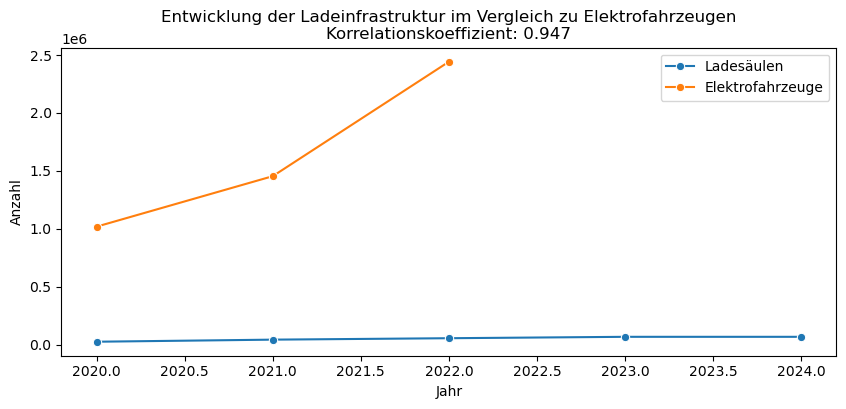

In [133]:
# Korrelationen Infrastrukturentwicklung
# Wie hat sich die Ladeinfrastruktur im Vergleich zu der Anzahl der zugelassenen Elektrofahrzeuge entwickelt?
stations_data = stations.groupby(stations['Open Date'].dt.year).size().cumsum().reset_index(name='Count')
stations_data = stations_data.rename(columns={'Open Date': 'Year'})

stations_data = stations_data[stations_data['Year'] >= 2020]

registrations_data = registrations.groupby(registrations['Year'])['Electric'].sum().reset_index(name='Count')

registrations_data = registrations_data[registrations_data['Year'] >= 2020]

merge = pd.merge(stations_data, registrations_data, on='Year')

# Korrelationskoeffizient berechnen
correlation_coefficient = merge['Count_x'].corr(merge['Count_y'])

plt.figure(figsize=(10,4))

# Ladesäulen
sns.lineplot(x='Year', y='Count', data=stations_data, label='Ladesäulen', marker='o')

# Elektrofahrzeuge
sns.lineplot(x='Year', y='Count', data=registrations_data, label='Elektrofahrzeuge', marker='o')

plt.title(f'Entwicklung der Ladeinfrastruktur im Vergleich zu Elektrofahrzeugen\nKorrelationskoeffizient: {correlation_coefficient:.3f}')
plt.xlabel('Jahr')
plt.ylabel('Anzahl')
plt.legend()
plt.show()

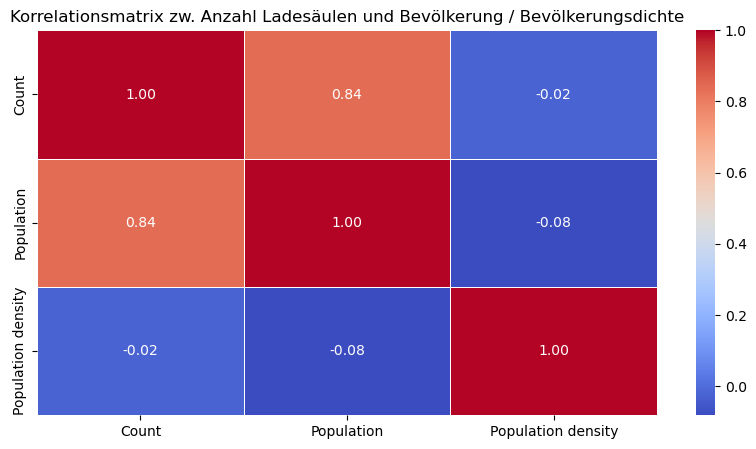

In [134]:
# Korrelation zw. der Anzahl Ladesäulen und anderen Faktoren, wie der Bevölkerung, Bevölkerungsdichte?
stations_corr = stations.groupby(stations['State']).size().reset_index(name='Count')
stations_corr = pd.merge(stations_corr, usa, left_on='State', right_on='Abbreviation')
stations_corr['Population density'] = stations_corr['Population'] / stations_corr['Land_area']

# Korrelationsmatrix erstellen
correlation_matrix = stations_corr[['Count', 'Population', 'Population density']].corr()

# Heatmap der Korrelationsmatrix erstellen
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Korrelationsmatrix zw. Anzahl Ladesäulen und Bevölkerung / Bevölkerungsdichte')
plt.show()